In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import math
from math import sqrt

from numpy import absolute
from numpy import mean
from numpy import std

from sklearn import metrics
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold
from sklearn import neighbors

!pip install tensorflow


import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import MeanSquaredError
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.random import set_seed

import xgboost as xgb


#### There is a lot of data, which will require a lot of computing resources, so I took only a part of it

In [2]:
#date_time_of_pickup was represented as an object so I converted it to a time variable
train = pd.read_csv(r'https://raw.githubusercontent.com/Premalatha-success/Datasets/main/TaxiFare.csv', nrows = 100000, )
test = pd.read_csv(r'https://raw.githubusercontent.com/Premalatha-success/Datasets/main/TaxiFare.csv')


In [3]:
train = pd.read_csv('https://raw.githubusercontent.com/Premalatha-success/Datasets/main/TaxiFare.csv')
train.head()

,unique_id,amount,date_time_of_pickup,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger
0,26:21.0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,52:16.0,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,35:00.0,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,30:42.0,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,51:00.0,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [4]:
print(train.shape)
print(test.shape)

(50000, 8)
(50000, 8)


In [5]:
train.head()

,unique_id,amount,date_time_of_pickup,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger
0,26:21.0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,52:16.0,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,35:00.0,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,30:42.0,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,51:00.0,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [6]:
train.dtypes

unique_id                object
amount                  float64
date_time_of_pickup      object
longitude_of_pickup     float64
latitude_of_pickup      float64
longitude_of_dropoff    float64
latitude_of_dropoff     float64
no_of_passenger           int64
dtype: object

In [7]:
train.describe()

,amount,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,11.364171,-72.509756,39.933759,-72.504616,39.926251,1.667840
std,9.685557,10.393860,6.224857,10.407570,6.014737,1.289195
min,-5.000000,-75.423848,-74.006893,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992062,40.734880,-73.991152,40.734372,1.000000
50%,8.500000,-73.981840,40.752678,-73.980082,40.753372,1.000000
75%,12.500000,-73.967148,40.767360,-73.963584,40.768167,2.000000
max,200.000000,40.783472,401.083332,40.851027,43.415190,6.000000


## From this we learn that
* The minimum fare is negative, which is impossible
* Some travel points are missing the city
* The maximum number of passengers is equal to 208, which is impossible
* The maximum fare also unreal

# Data Cleaning & Feature Engineering

#### Find, if we have data that has no value

In [8]:
print(train.isnull().sum())

unique_id               0
amount                  0
date_time_of_pickup     0
longitude_of_pickup     0
latitude_of_pickup      0
longitude_of_dropoff    0
latitude_of_dropoff     0
no_of_passenger         0
dtype: int64


In [9]:
train = train.dropna(how = 'any', axis = 'rows')

In [10]:
print('Old size: %d' % len(train))

Old size: 50000


#### There will be no negative tax and you may not be able to pay more than a certain limit depending on the circumstances, let's say this limit is 200\\$
Also, the minimum fare for a New York taxi is 2,50\\$  

In [11]:
train = train.drop(train[train.amount<2.5].index, axis = 0)
train = train.drop(train[train.amount>300].index, axis = 0)

#### Delete the data whose no_of_passenger exceeded 6, because it cannot physically fit more in the taxi and it is not allowed. Taxi can also move without passenger and carry cargo, so lets permit no_of_passenger == 0 data


In [12]:
train = train.drop(train[train['no_of_passenger']>6].index, axis = 0)
train = train.drop(train[train['no_of_passenger']<0].index, axis = 0)

#### Remove the latitude_of_pickup data whose values are greater than 90 and less than -90, because latitudes are between -90 and 90 degrees

In [13]:
train = train.drop(train[train['latitude_of_pickup']<-90].index, axis = 0)
train = train.drop(train[train['latitude_of_pickup']>90].index, axis = 0)

#### Remove the longitude_of_pickup data whose values are greater than 180 and less than -180, because longitudes are between -180 and 180 degrees

In [14]:
train = train.drop(train[train['longitude_of_pickup']<-180].index, axis = 0)
train = train.drop(train[train['longitude_of_pickup']>180].index, axis = 0)

#### Repeat the same for latitude_of_dropoff and longitude_of_dropoff

In [15]:
train = train.drop(train[train['latitude_of_dropoff']<-90].index, axis = 0)
train = train.drop(train[train['latitude_of_dropoff']>90].index, axis = 0)

train = train.drop(train[train['longitude_of_dropoff']<-180].index, axis = 0)
train = train.drop(train[train['longitude_of_dropoff']>180].index, axis = 0)

#### The geographical location may correspond to the real one, but not to New York area, so let's filter the existing data. For this, let's introduce the conditional city limits

In [16]:
def select_outside_boundingbox(df, BB):
    filter_df = df.loc[(df['longitude_of_pickup'] < BB[0]) | (df['longitude_of_pickup'] > BB[1]) | \
           (df['latitude_of_pickup'] < BB[2]) | (df['latitude_of_pickup'] > BB[3]) | \
           (df['longitude_of_dropoff'] < BB[0]) | (df['longitude_of_dropoff'] > BB[1]) | \
           (df['latitude_of_dropoff'] < BB[2]) | (df['latitude_of_dropoff'] > BB[3])]

    return filter_df

NYC_BB = (-74.5, -72.8, 40.5, 41.8)

In [17]:
outliers = select_outside_boundingbox(train, NYC_BB)
outliers

,unique_id,amount,date_time_of_pickup,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger
11,24:00.0,5.5,2012-12-24 11:24:00 UTC,0.0,0.0,0.0,0.0,3
15,57:00.0,5.0,2013-11-23 12:57:00 UTC,0.0,0.0,0.0,0.0,1
26,01:00.0,6.5,2011-02-07 20:01:00 UTC,0.0,0.0,0.0,0.0,1
124,22:00.0,8.0,2013-01-17 17:22:00 UTC,0.0,0.0,0.0,0.0,2
192,08:00.0,3.7,2010-09-05 17:08:00 UTC,0.0,0.0,0.0,0.0,5
...,...,...,...,...,...,...,...,...
49625,50:27.0,12.1,2012-01-09 19:50:27 UTC,0.0,0.0,0.0,0.0,1
49816,54:00.0,4.9,2012-02-20 00:54:00 UTC,0.0,0.0,0.0,0.0,1
49845,57:15.0,6.6,2009-03-02 21:57:15 UTC,0.0,0.0,0.0,0.0,3
49856,25:00.0,10.9,2010-04-19 17:25:00 UTC,0.0,0.0,0.0,0.0,5


In [18]:
train = train.drop(outliers.index, axis = 0)

In [19]:
print('New size: %d' % len(train))

New size: 48934


In [20]:
#key column and date_time_of_pickup column of Test set should also be presented as time data
#test['key'] = pd.to_datetime(test['key'])
#test['date_time_of_pickup']  = pd.to_datetime(test['date_time_of_pickup'])

In [21]:
test.dtypes

unique_id                object
amount                  float64
date_time_of_pickup      object
longitude_of_pickup     float64
latitude_of_pickup      float64
longitude_of_dropoff    float64
latitude_of_dropoff     float64
no_of_passenger           int64
dtype: object

#### We can understand displacement through start and end points.

#### We will use the Haversine formula to calculate the distance between two geolocations

In [22]:
train["loc1"] = train[["latitude_of_pickup","longitude_of_pickup"]].apply(tuple, axis=1)
train["loc2"] = train[["latitude_of_dropoff","longitude_of_dropoff"]].apply(tuple, axis=1)

In [23]:
!pip install haversine
import haversine as hs


train['H_Distance'] = train.apply(lambda row: hs.haversine(row.loc1,row.loc2), axis=1)

#### Let's also calculate the distance using the Chebyshev method

In [24]:
def chebyshev(pickup_long, dropoff_long, pickup_lat, dropoff_lat):
    return np.maximum(np.absolute(pickup_long - dropoff_long), np.absolute(pickup_lat - dropoff_lat))

train['Chebyshev'] = chebyshev(train['longitude_of_pickup'], train['longitude_of_dropoff'], train['latitude_of_pickup'], train['latitude_of_dropoff'])

In [25]:
train.head()

,unique_id,amount,date_time_of_pickup,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger,loc1,loc2,H_Distance,Chebyshev
0,26:21.0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,"(40.721319, -73.844311)","(40.712278, -73.84161)",1.030765,0.009041
1,52:16.0,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,"(40.711303, -74.016048)","(40.782004, -73.979268)",8.450145,0.070701
2,35:00.0,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,"(40.76127, -73.982738)","(40.750562, -73.991242)",1.389527,0.010708
3,30:42.0,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,"(40.733143, -73.98713)","(40.758092, -73.991567)",2.799274,0.024949
4,51:00.0,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,"(40.768008, -73.968095)","(40.783762, -73.956655)",1.999160,0.015754


In [26]:
train["date_time_of_pickup"] = pd.to_datetime(train["date_time_of_pickup"])

train["hour"] = train.date_time_of_pickup.dt.hour
train["day_of_week"] = train.date_time_of_pickup.dt.weekday
train["day_of_month"] = train.date_time_of_pickup.dt.day
train["week"] = train.date_time_of_pickup.dt.week
train["month"] = train.date_time_of_pickup.dt.month
train["year"] = train.date_time_of_pickup.dt.year - 2000

train['minute'] =train['date_time_of_pickup'].dt.minute
train['second'] = train['date_time_of_pickup'].dt.second
train['dayofyear'] = train['date_time_of_pickup'].dt.dayofyear

<ipython-input-26-ebf23db8d6ea>:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  train["week"] = train.date_time_of_pickup.dt.week


In [27]:
train.head()

,unique_id,amount,date_time_of_pickup,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger,loc1,loc2,...,Chebyshev,hour,day_of_week,day_of_month,week,month,year,minute,second,dayofyear
0,26:21.0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,"(40.721319, -73.844311)","(40.712278, -73.84161)",...,0.009041,17,0,15,25,6,9,26,21,166
1,52:16.0,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,"(40.711303, -74.016048)","(40.782004, -73.979268)",...,0.070701,16,1,5,1,1,10,52,16,5
2,35:00.0,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,"(40.76127, -73.982738)","(40.750562, -73.991242)",...,0.010708,0,3,18,33,8,11,35,0,230
3,30:42.0,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,"(40.733143, -73.98713)","(40.758092, -73.991567)",...,0.024949,4,5,21,16,4,12,30,42,112
4,51:00.0,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,"(40.768008, -73.968095)","(40.783762, -73.956655)",...,0.015754,7,1,9,10,3,10,51,0,68


#### Add a variable that determines how much each kilometer of travel costs

In [28]:
train["fare_to_dist_ratio"] = train["amount"] / ( train["H_Distance"]+0.0001)

#### Remove those whose start and end points match

In [29]:
train = train.drop(train[train['loc1']==train['loc2']].index, axis = 0)


#### It is necessary to take into account the circumstances of calling at the airport, according to which the fee changes dramatically. For this, let's write the given function that shows how many kilometers away the point is from the airport


In [30]:
def add_distances_from_airport(dataset):
    #coordinates of all these airports
    jfk_coords = (40.639722, -73.778889)
    ewr_coords = (40.6925, -74.168611)
    lga_coords = (40.77725, -73.872611)

    dataset['pickup_jfk_distance'] = dataset.apply(lambda row: hs.haversine(jfk_coords,row.loc1), axis=1)
    dataset['dropof_jfk_distance'] = dataset.apply(lambda row: hs.haversine(jfk_coords,row.loc2), axis=1)


    dataset['pickup_ewr_distance'] = dataset.apply(lambda row: hs.haversine(ewr_coords,row.loc1), axis=1)
    dataset['dropof_ewr_distance'] = dataset.apply(lambda row: hs.haversine(ewr_coords,row.loc2), axis=1)


    dataset['pickup_lga_distance'] = dataset.apply(lambda row: hs.haversine(lga_coords,row.loc1), axis=1)
    dataset['dropof_lga_distance'] = dataset.apply(lambda row: hs.haversine(lga_coords,row.loc2), axis=1)

    return dataset


train = add_distances_from_airport(train)


### Let's repeat the same procedures on the test part

test['date_time_of_pickup']  = pd.to_datetime(test['date_time_of_pickup'])

test["loc1"] = test[["latitude_of_pickup","longitude_of_pickup"]].apply(tuple, axis=1)
test["loc2"] = test[["latitude_of_dropoff","longitude_of_dropoff"]].apply(tuple, axis=1)

test['H_Distance'] = test.apply(lambda row: hs.haversine(row.loc1,row.loc2), axis=1)

test['Chebyshev'] = chebyshev(test['longitude_of_pickup'], test['longitude_of_dropoff'], test['latitude_of_pickup'], test['latitude_of_dropoff'])


test["hour"] = test.date_time_of_pickup.dt.hour
test["day_of_week"] = test.date_time_of_pickup.dt.weekday
test["day_of_month"] = test.date_time_of_pickup.dt.day
test["week"] = test.date_time_of_pickup.dt.week
test["month"] = test.date_time_of_pickup.dt.month
test["year"] = test.date_time_of_pickup.dt.year - 2000

test['minute'] =test['date_time_of_pickup'].dt.minute
test['second'] = test['date_time_of_pickup'].dt.second
test['dayofyear'] = test['date_time_of_pickup'].dt.dayofyear

test = add_distances_from_airport(test)

In [31]:
def downcast(df):

    df_int = df.select_dtypes(include=['int64', 'int32', 'int16', 'int8', 'int'])
    df[df_int.columns] = df_int.apply(pd.to_numeric,downcast='unsigned')

    df_float = df.select_dtypes(include=['float64', 'float32', 'float16', 'float'])
    df[df_float.columns] = df_float.apply(pd.to_numeric,downcast='float')

    return df
downcast(train)
downcast(test)
train.dtypes

unique_id                            object
amount                              float32
date_time_of_pickup     datetime64[ns, UTC]
longitude_of_pickup                 float32
latitude_of_pickup                  float32
longitude_of_dropoff                float32
latitude_of_dropoff                 float32
no_of_passenger                       uint8
loc1                                 object
loc2                                 object
H_Distance                          float32
Chebyshev                           float32
hour                                  uint8
day_of_week                           uint8
day_of_month                          uint8
week                                  uint8
month                                 uint8
year                                  uint8
minute                                uint8
second                                uint8
dayofyear                            uint16
fare_to_dist_ratio                  float64
pickup_jfk_distance             

## Map visualization


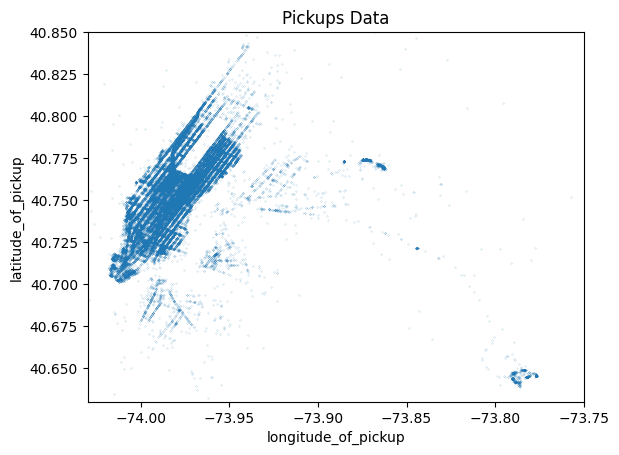

In [32]:
train.plot(y='latitude_of_pickup',x='longitude_of_pickup',kind="scatter",alpha=0.7,s=0.02)
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
plt.title("Pickups Data")

plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

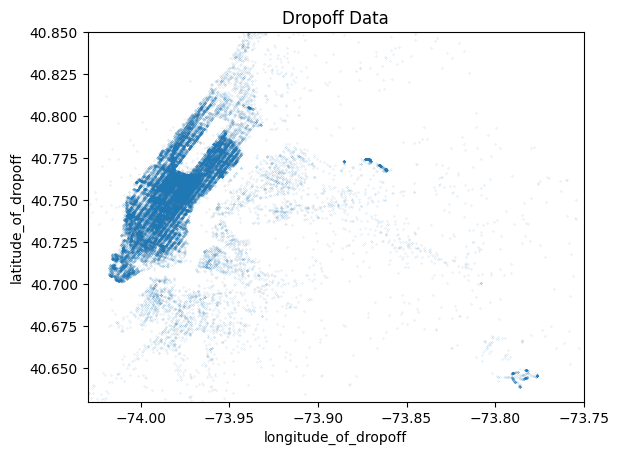

In [33]:
train.plot(y='latitude_of_dropoff',x='longitude_of_dropoff',kind="scatter",alpha=0.5,s=0.02)
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
plt.title("Dropoff Data")

plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

In [34]:
import folium


long_trips=train[train['H_Distance']>=10]

drop_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 12)

### For each pickup point add a circlemarker

for index, row in long_trips.iterrows():

    folium.CircleMarker([row['latitude_of_dropoff'], row['longitude_of_dropoff']],
                        radius=3,
                        color="green",
                        fill_opacity=0.9
                       ).add_to(drop_map)
for index, row in long_trips.iterrows():

    folium.CircleMarker([row['latitude_of_pickup'], row['longitude_of_pickup']],
                        radius=3,
                        color="blue",
                        fill_opacity=0.9
                       ).add_to(drop_map)
drop_map

Output hidden; open in https://colab.research.google.com to view.

## EDA

(0.0, 100.0)

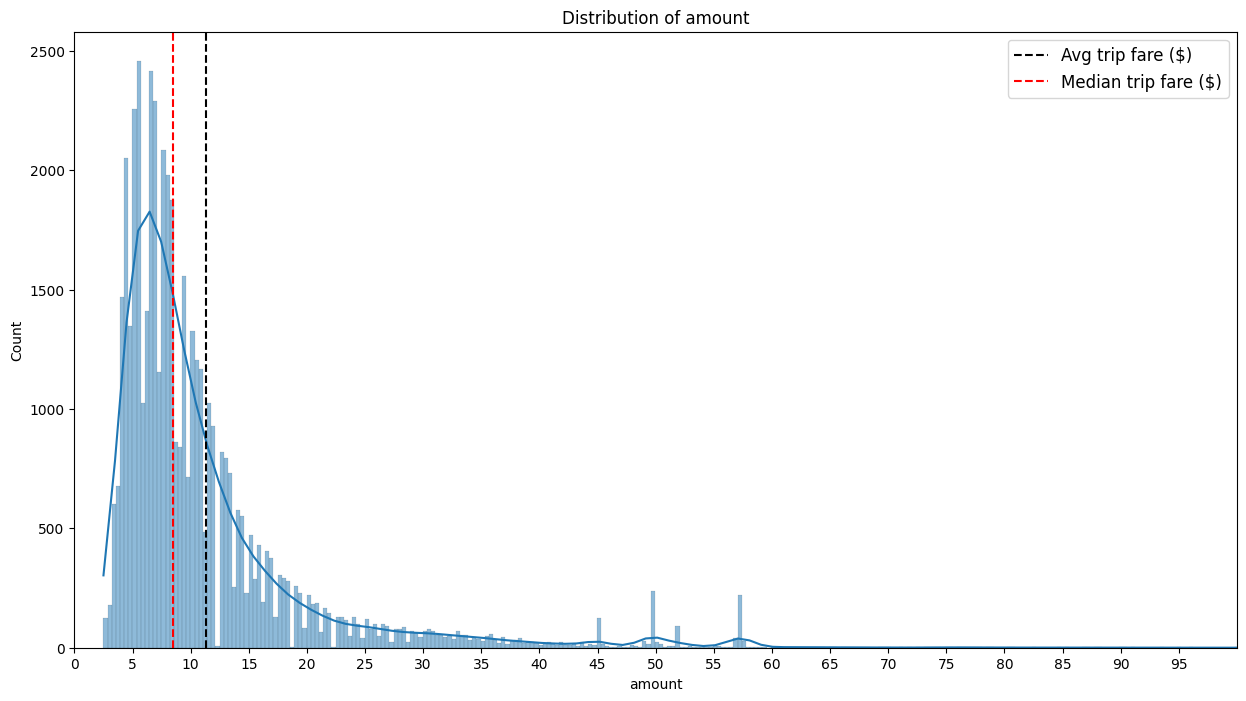

In [35]:
sns.histplot(data=train,x="amount",kde=True)

plt.axvline(train["amount"].mean(),color = "k",
            linestyle = "dashed",label = "Avg trip fare ($)")
plt.axvline(train["amount"].median(),color = "r",
            linestyle = "dashed",label = "Median trip fare ($)")

plt.title("Distribution of amount")
plt.xticks(np.arange(0, 100, step=5))
plt.legend(loc = "best",prop = {"size" : 12})
plt.gcf().set_size_inches(15,8)
plt.xlim(0,100)

##### A right-skewed distribution
* #### Most taxi fares range from $2.5\\$-20\\$.
* #### The average taxi fee varies between 10\\$-12\\$
* #### 45\\$-50\\$-57\\$ peaks are observed, which fixed fee

(0.0, 30.0)

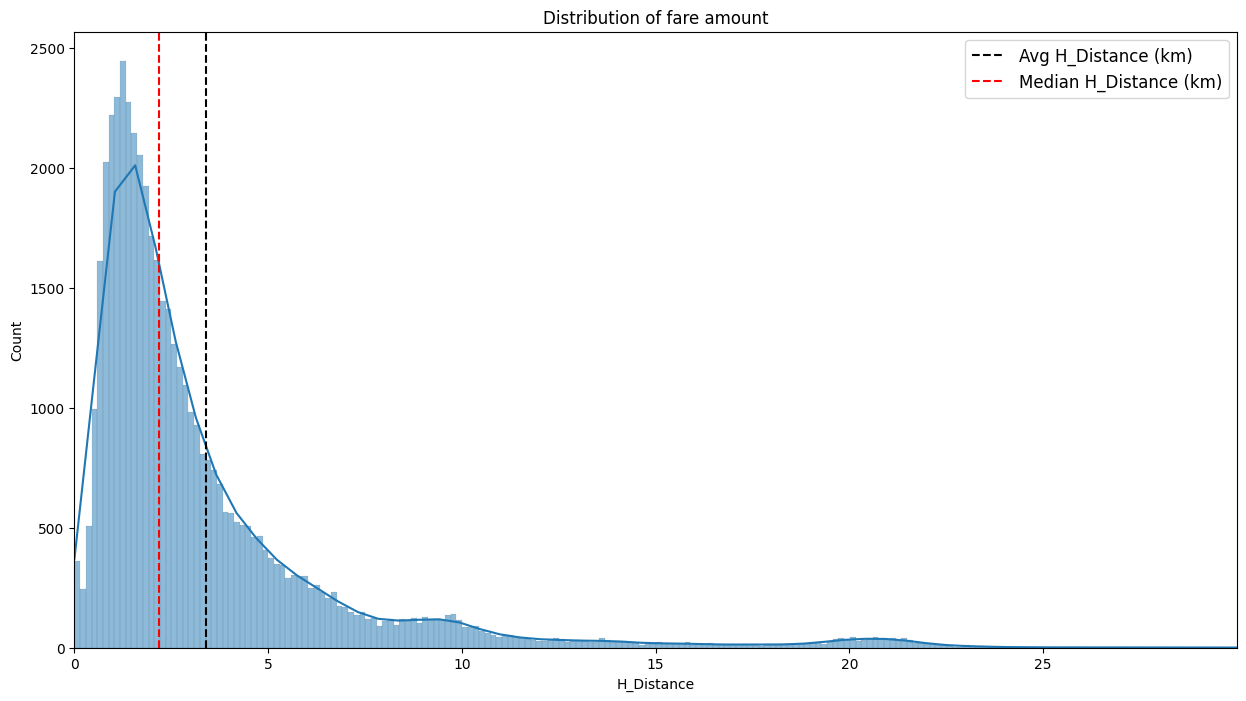

In [36]:
sns.histplot(data=train,x="H_Distance",kde=True)

plt.axvline(train["H_Distance"].mean(),color = "k",
            linestyle = "dashed",label = "Avg H_Distance (km)")
plt.axvline(train["H_Distance"].median(),color = "r",
            linestyle = "dashed",label = "Median H_Distance (km)")

plt.title("Distribution of fare amount")
plt.xticks(np.arange(0, 30, step=5))
plt.legend(loc = "best",prop = {"size" : 12})
plt.gcf().set_size_inches(15,8)
plt.xlim(0,30)

* #### Passengers travel an average of 3-5 km by taxi

#### 1. Does the number of passengers affect the fare?

Text(0, 0.5, 'Frequency')

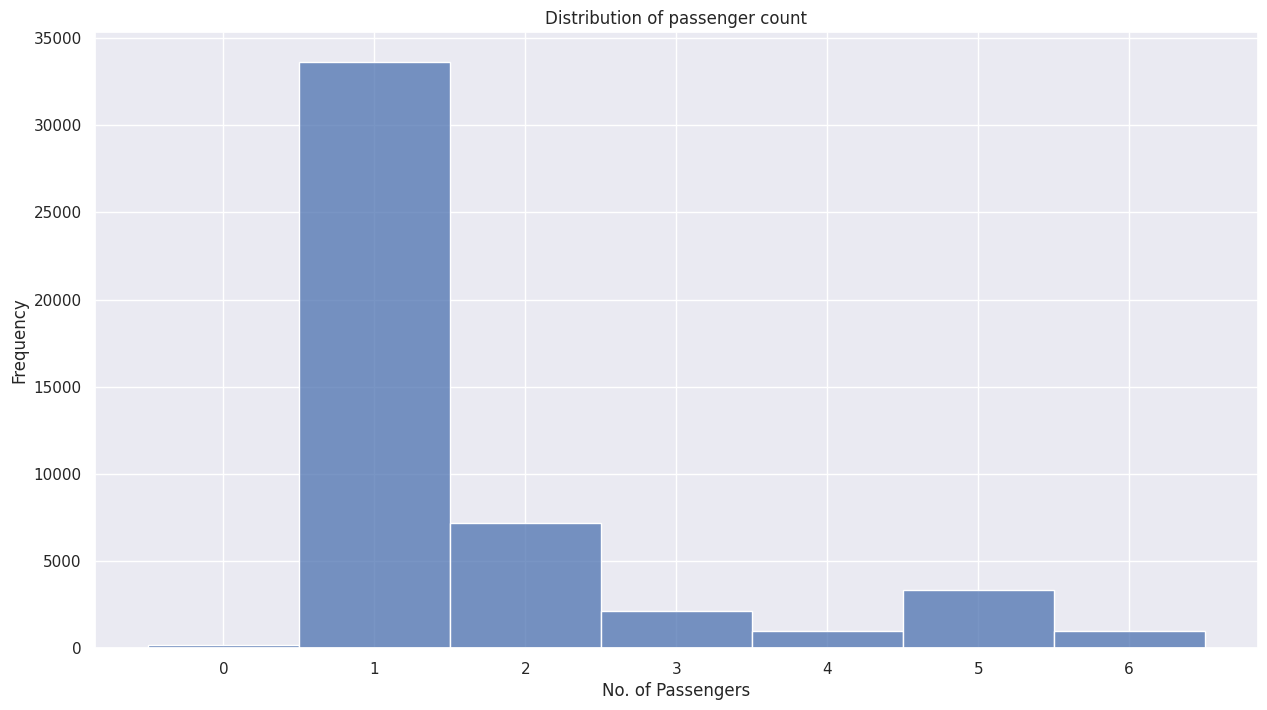

In [37]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.histplot(data=train, x="no_of_passenger", stat="count", discrete=True)
plt.title("Distribution of passenger count")
plt.xlabel('No. of Passengers')
plt.ylabel('Frequency')

* #### Most of the passengers were traveling alone

Text(0, 0.5, 'Fare')

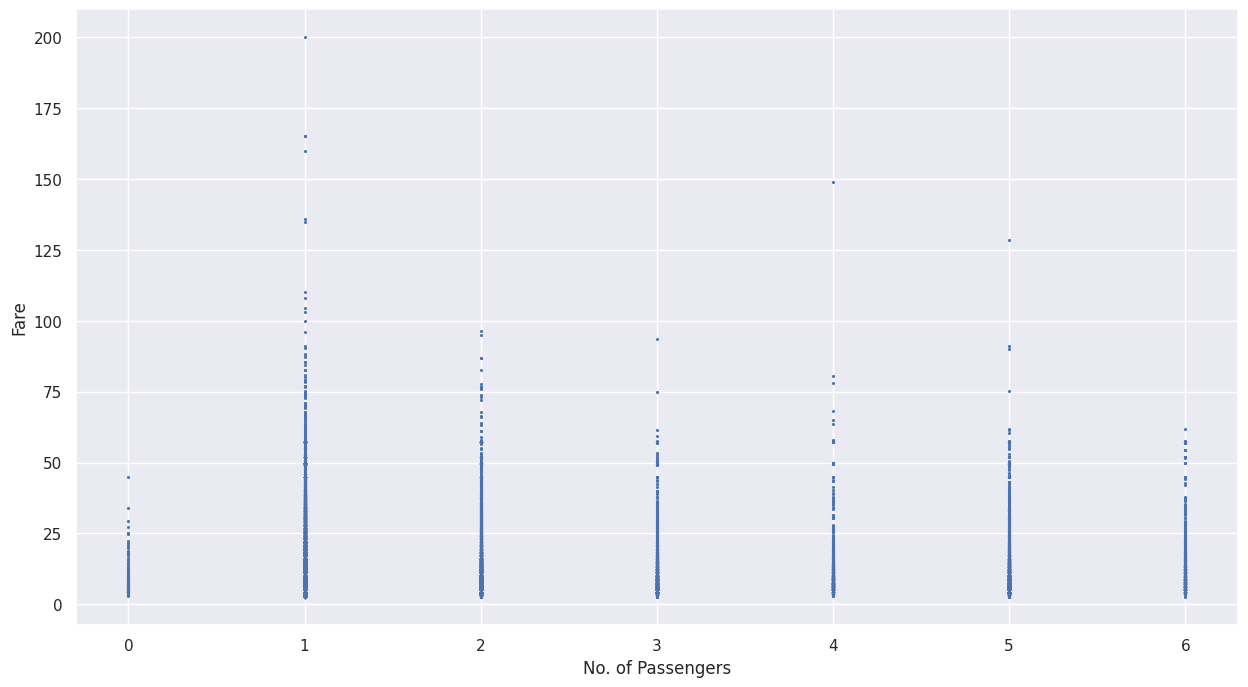

In [38]:
plt.figure(figsize=(15,8))
plt.scatter(x=train['no_of_passenger'], y=train['amount'], s=1.5)
plt.xlabel('No. of Passengers')
plt.ylabel('Fare')

* #### One-passenger taxi has more passengers whose fare is higher

#### 2. Does the pick-up date and time affect the fare?

<ipython-input-39-e90f6c5ebb5c>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(train.corr(),linewidths=0.1,vmax=1.0,vmin=0,


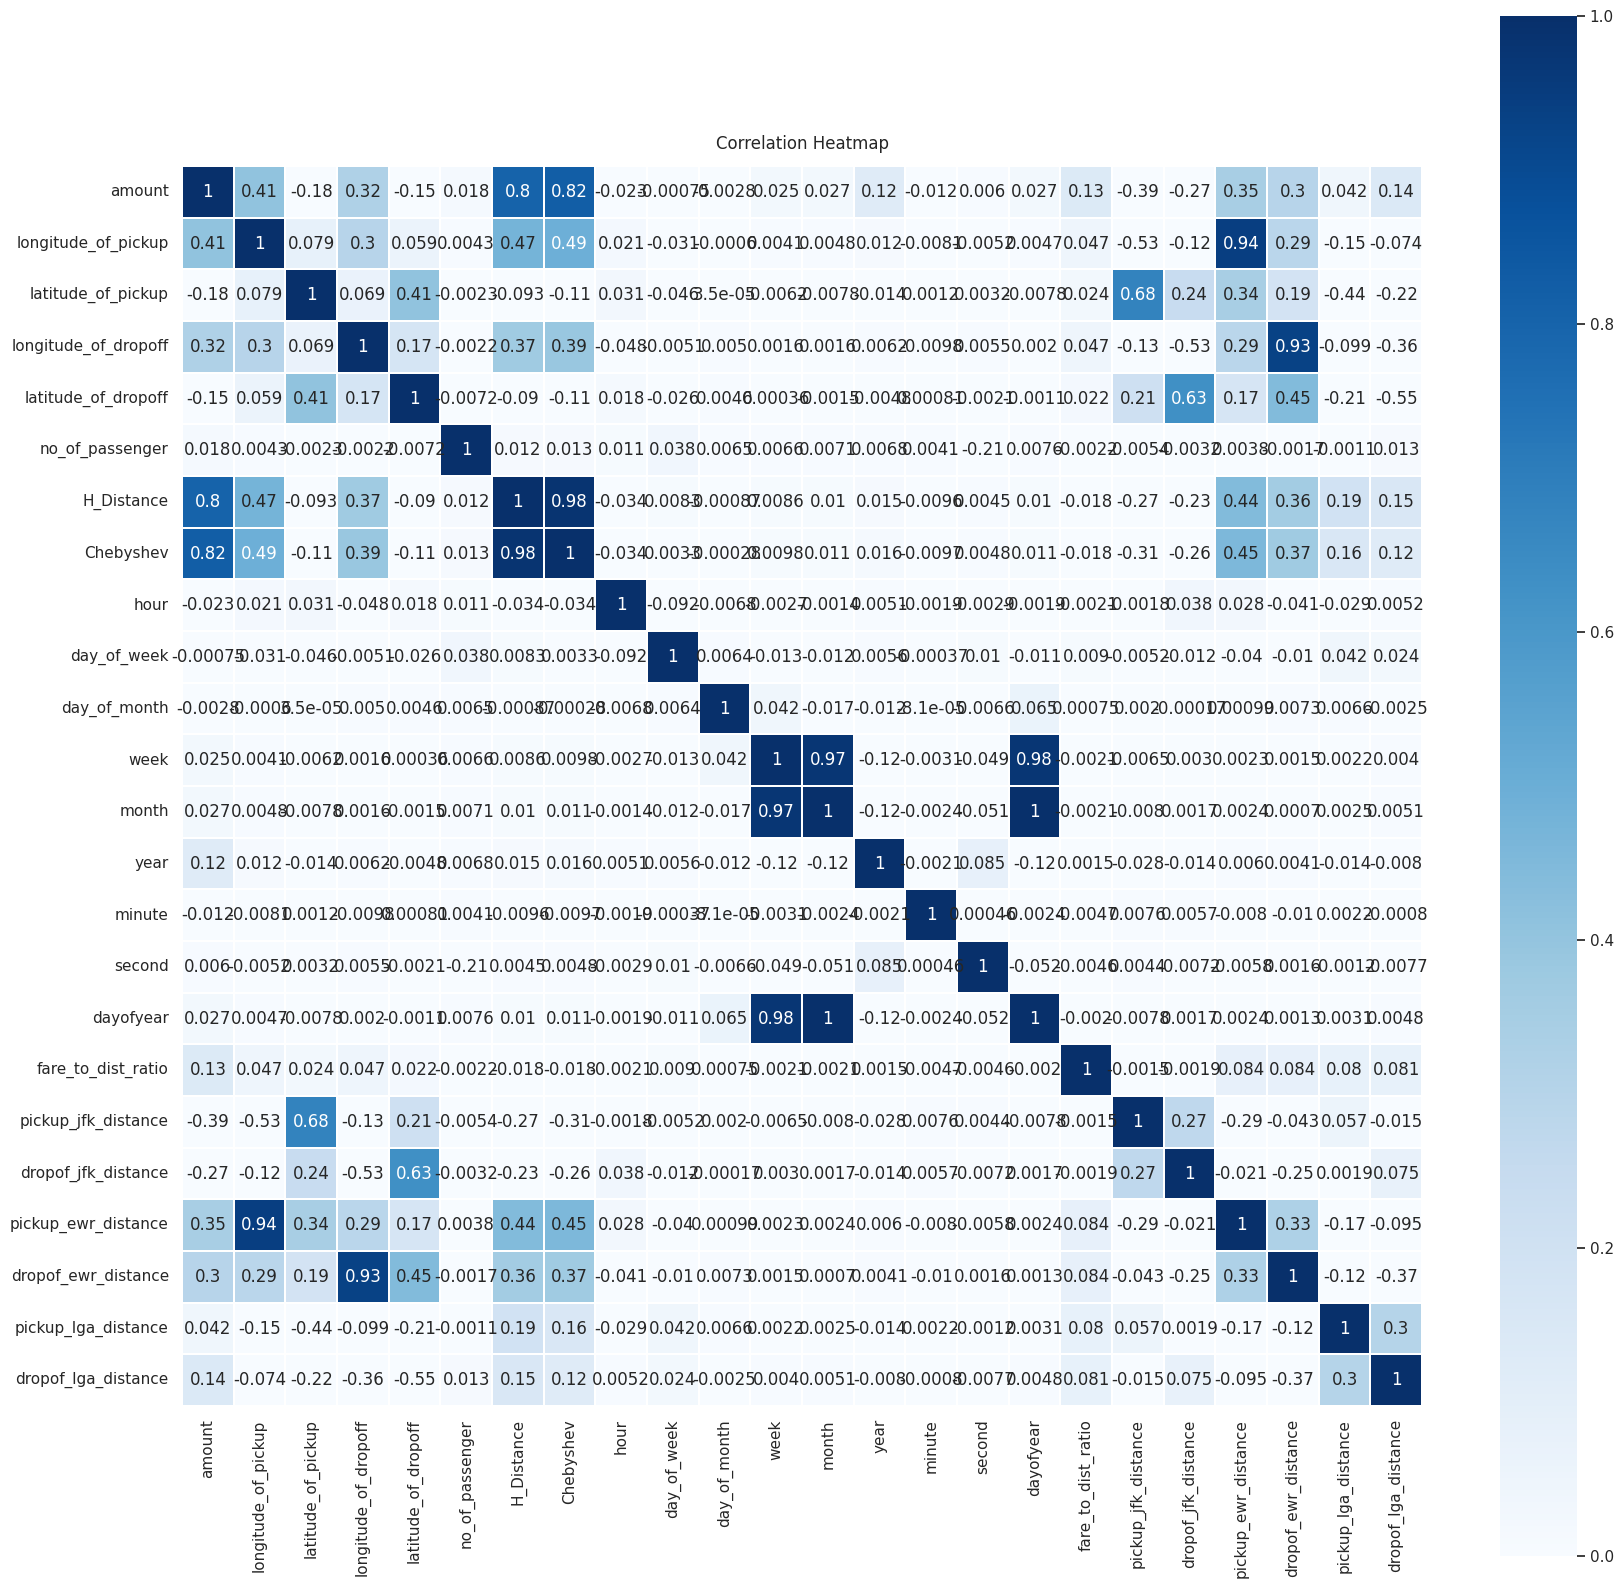

In [39]:
colormap = plt.cm.RdBu
plt.figure(figsize=(20, 20))
heatmap = sns.heatmap(train.corr(),linewidths=0.1,vmax=1.0,vmin=0,
            square=True, cmap="Blues", linecolor='white', annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

Text(0, 0.5, 'Fare')

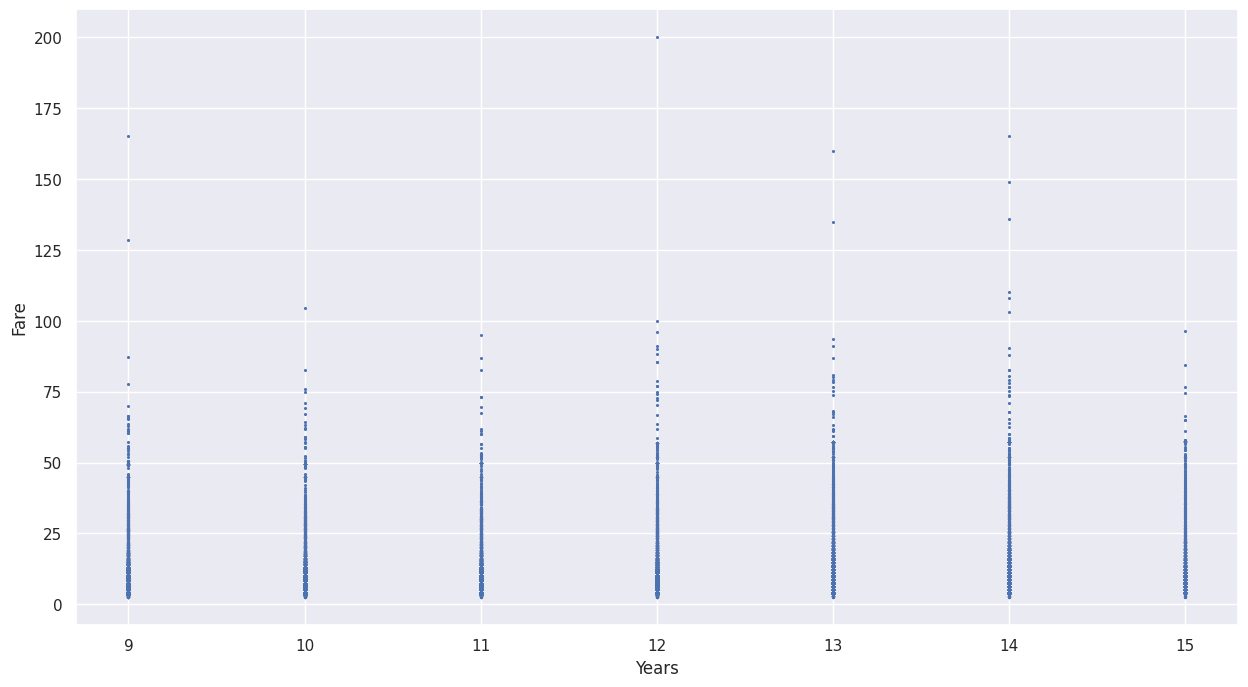

In [40]:
plt.figure(figsize=(15,8))
plt.scatter(x=train['year'], y=train['amount'], s=1.5)
plt.xlabel('Years')
plt.ylabel('Fare')

In [41]:
train[['amount','year']].corr()

,amount,year
amount,1.00000,0.12377
year,0.12377,1.00000


* #### The rate does not change significantly over the years

Text(0, 0.5, 'Fare')

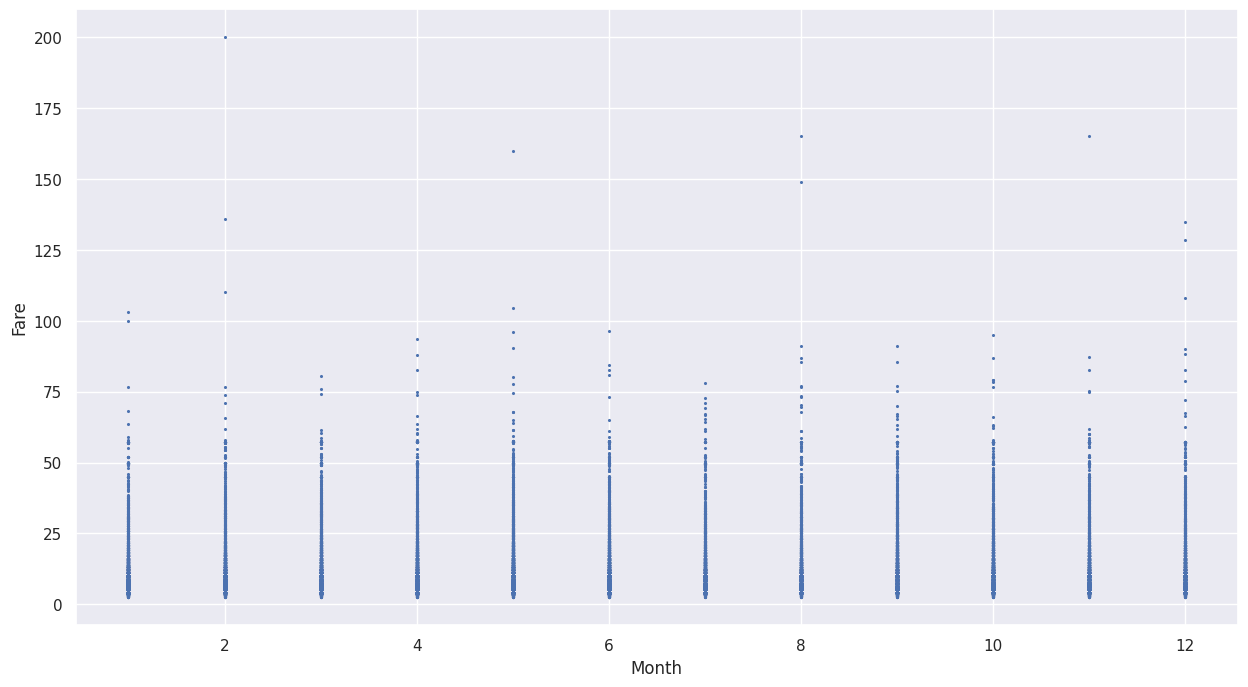

In [42]:
plt.figure(figsize=(15,8))
plt.scatter(x=train['month'], y=train['amount'], s=1.5)
plt.xlabel('Month')
plt.ylabel('Fare')

* #### The rate is uniform throughout the months

Text(0, 0.5, 'Fare')

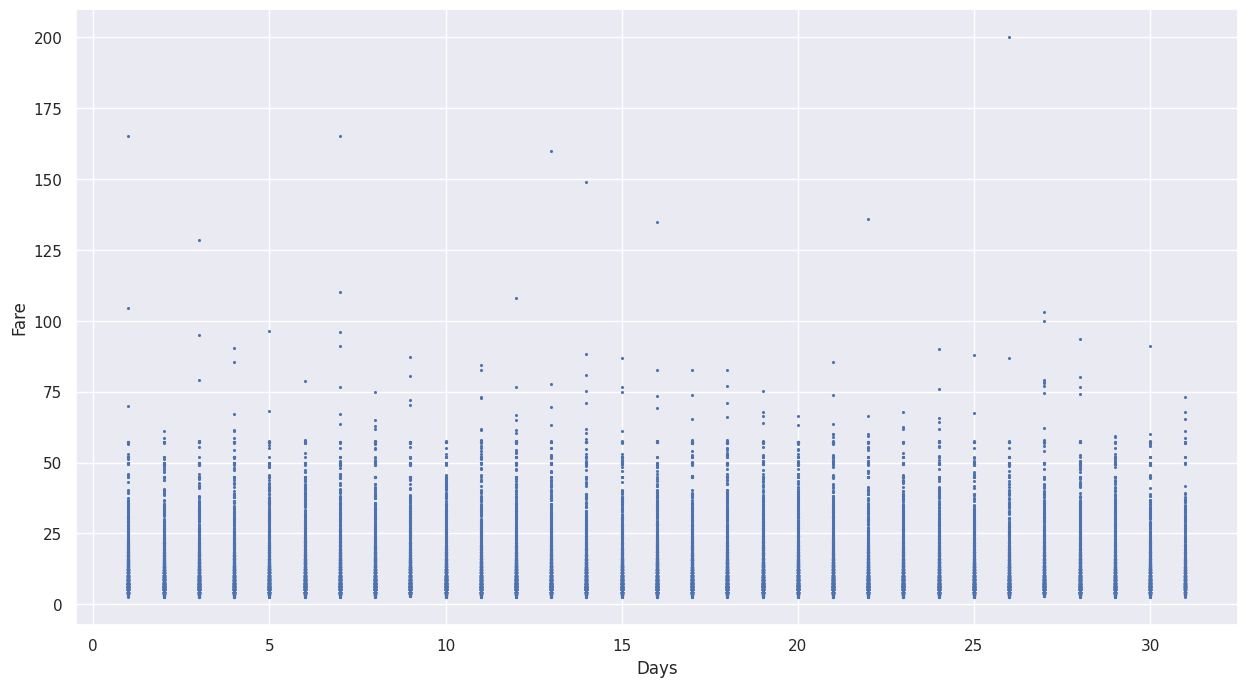

In [43]:
plt.figure(figsize=(15,8))
plt.scatter(x=train['day_of_month'], y=train['amount'], s=1.5)
plt.xlabel('Days')
plt.ylabel('Fare')

* #### The fare is uniform throughout the month

Text(0, 0.5, 'Frequency')

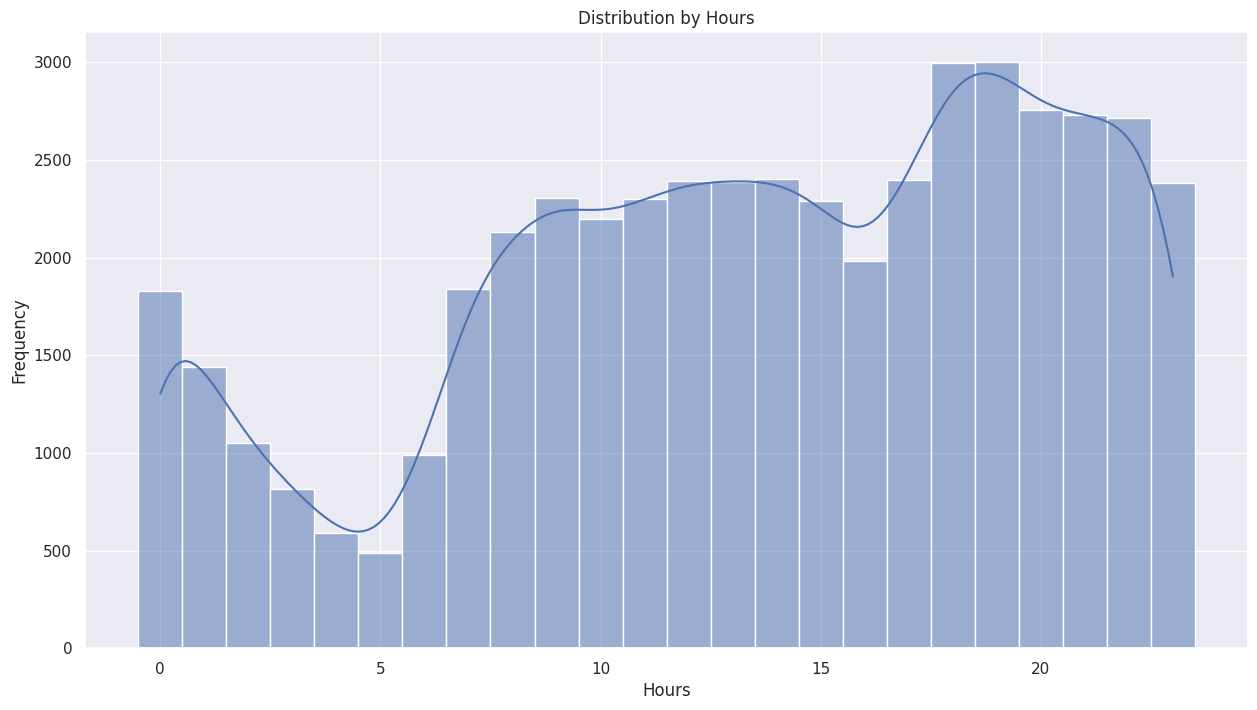

In [44]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.histplot(data=train, x="hour", stat="count", discrete=True, kde=True)
plt.title("Distribution by Hours")
plt.xlabel('Hours')
plt.ylabel('Frequency')

* #### Taxi fares are rare at 5am and reaches the maximum at 7pm

Text(0, 0.5, 'Fare')

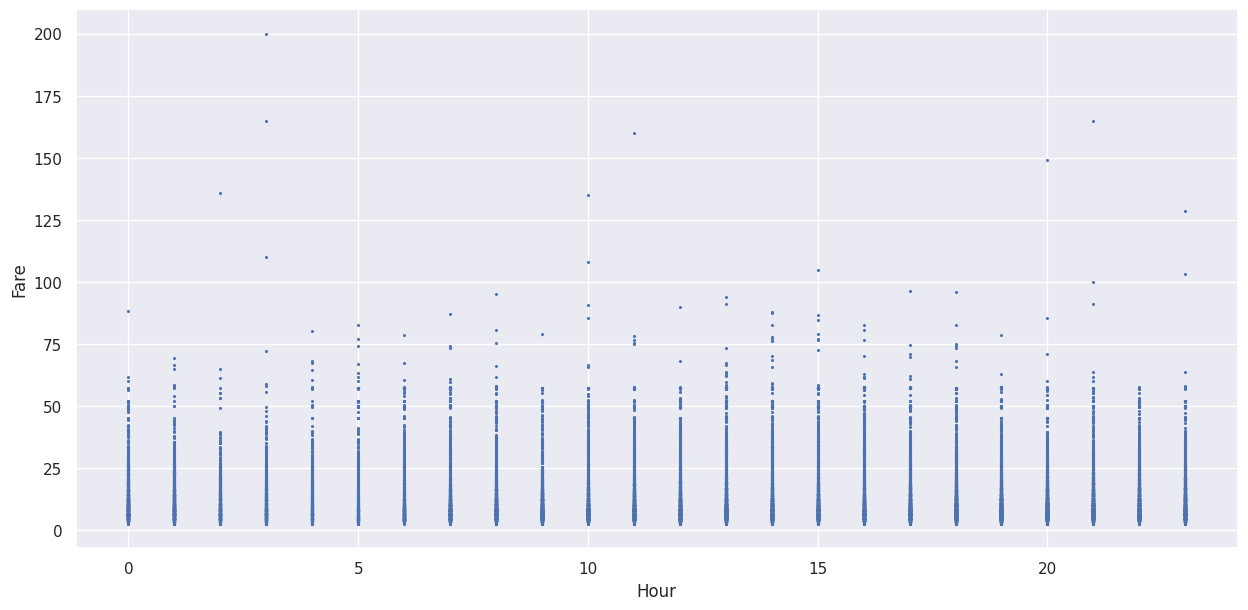

In [45]:
plt.figure(figsize=(15,7))
plt.scatter(x=train['hour'], y=train['amount'], s=1.5)
plt.xlabel('Hour')
plt.ylabel('Fare')

In [46]:
train[train.no_of_passenger <7][['amount','no_of_passenger']].corr()


,amount,no_of_passenger
amount,1.000000,0.017816
no_of_passenger,0.017816,1.000000


In [47]:
def time_slicer(df, timeframes, value, color="purple"):
    """
    Function to count observation occurrence through different lenses of time.
    """
    f, ax = plt.subplots(len(timeframes), figsize = [12,12])
    for i,x in enumerate(timeframes):
        df.loc[:,[x,value]].groupby([x]).mean().plot(ax=ax[i],color=color)
        ax[i].set_ylabel(value.replace("_", " ").title())
        ax[i].set_title("{} by {}".format(value.replace("_", " ").title(), x.replace("_", " ").title()))
        ax[i].set_xlabel("")
    plt.tight_layout(pad=0)

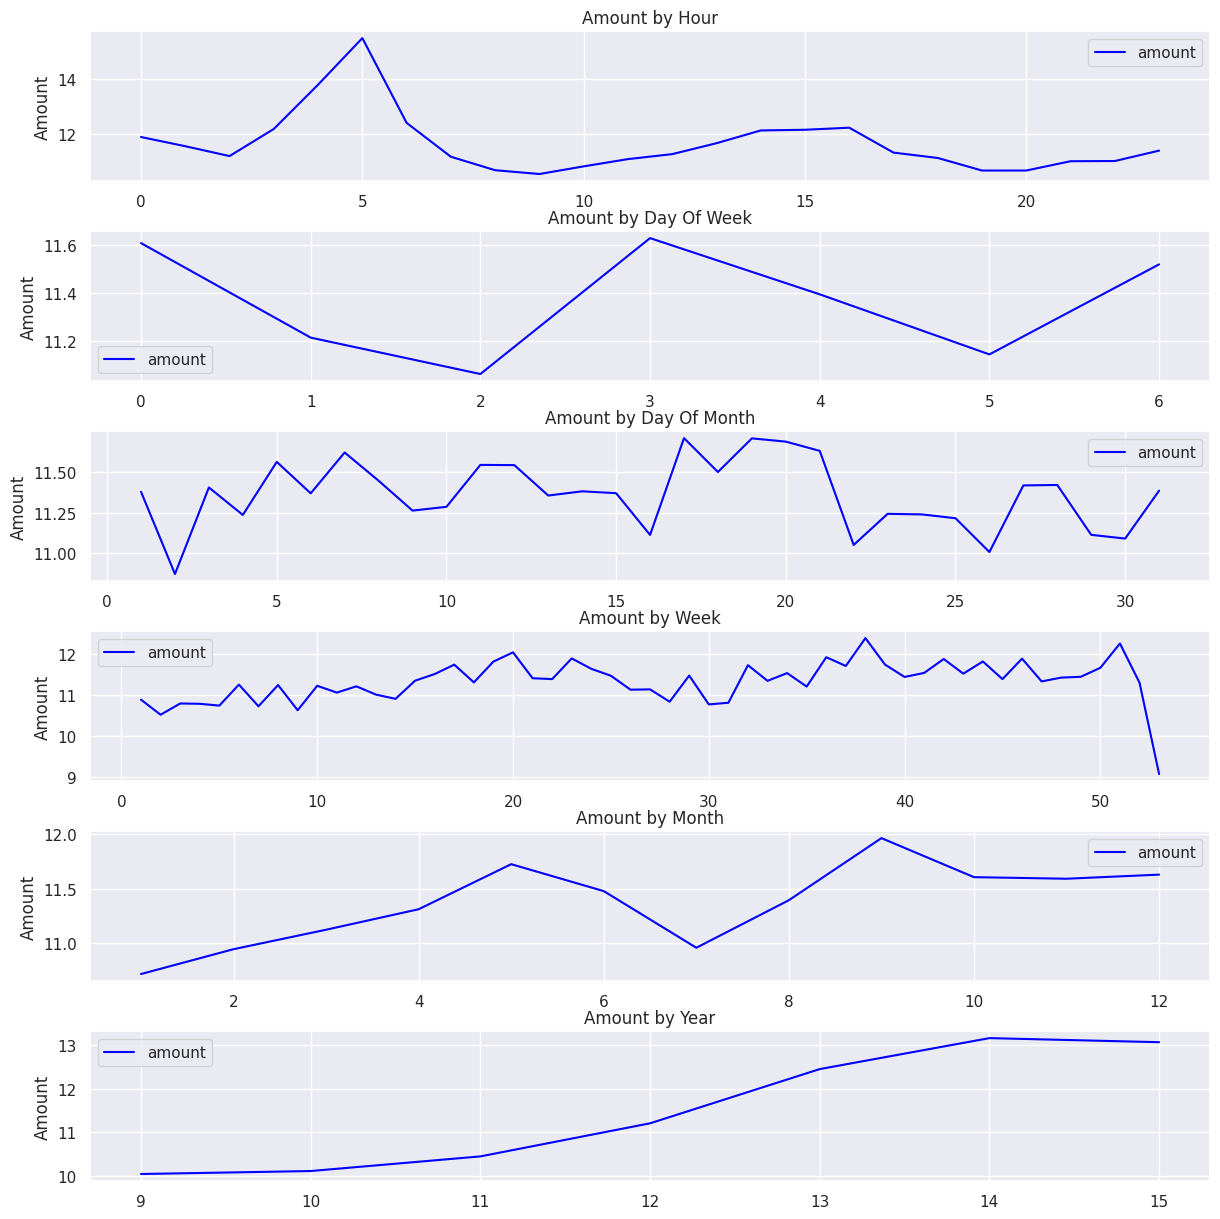

In [48]:
time_slicer(df=train, timeframes=['hour', 'day_of_week','day_of_month', 'week', 'month', 'year',], value = "amount", color="blue")

* #### The higher the demand, the lower the fee and vice versa
* #### Average fares peak on Mondays and Thursdays
* #### The average fee has been increasing over the years

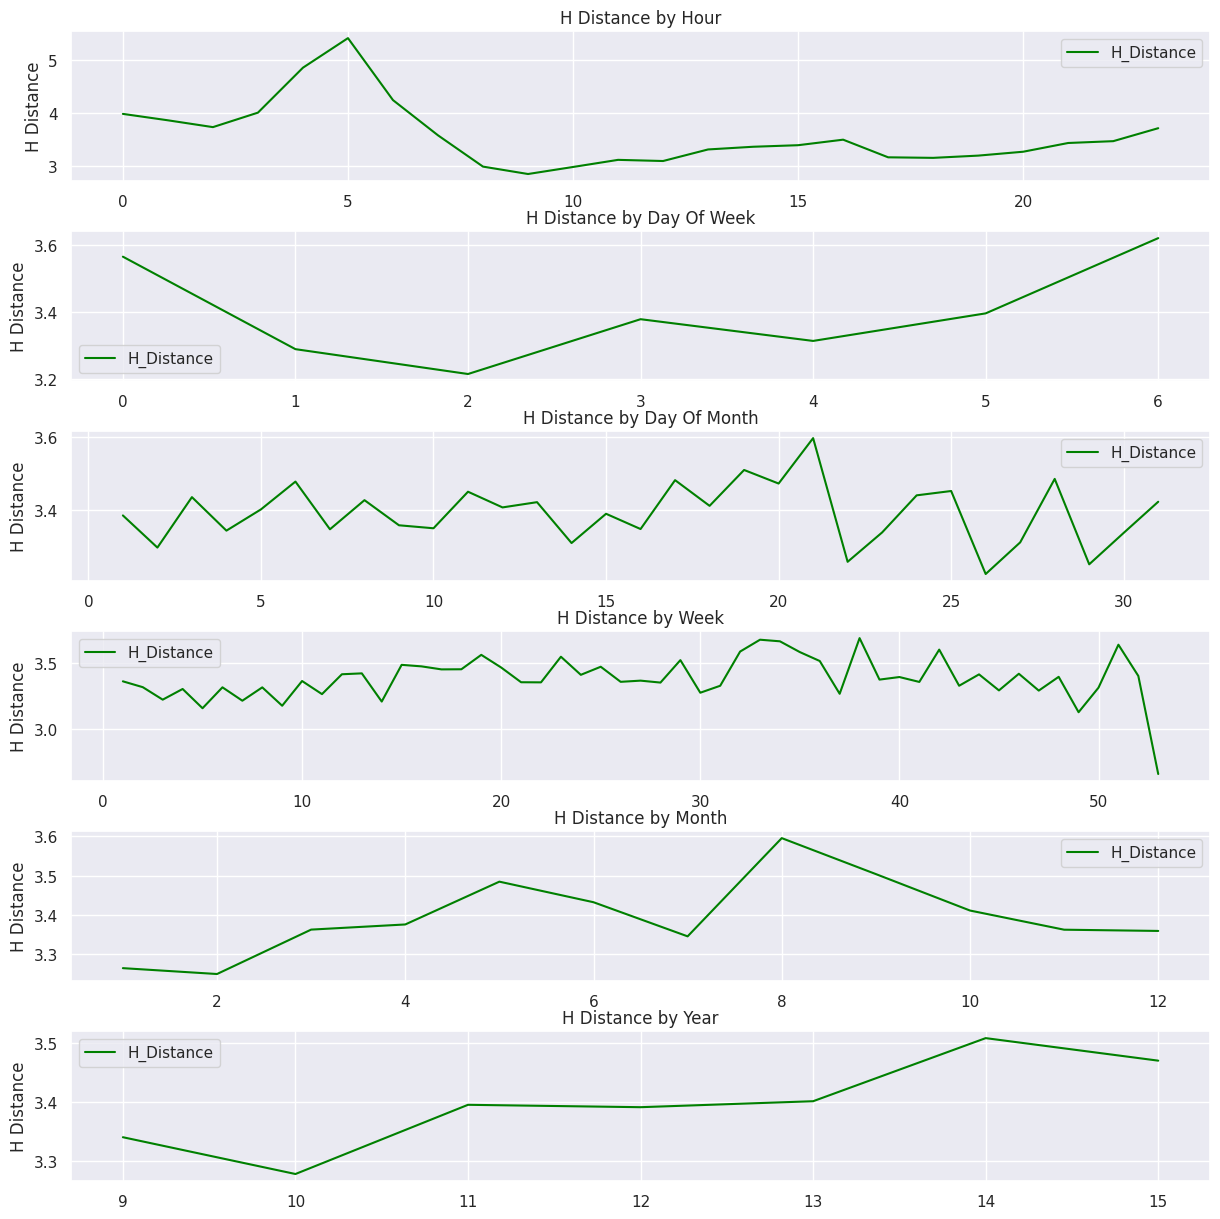

In [49]:
time_slicer(df=train, timeframes=['hour', 'day_of_week','day_of_month', 'week', 'month', 'year',], value = "H_Distance", color="green")

In [50]:
train[['amount','H_Distance']].corr()

,amount,H_Distance
amount,1.000000,0.801019
H_Distance,0.801019,1.000000


* #### The correlation number between these two values is high, as a result the graphs are very similar to each other
* #### At 5 o'clock in the morning, some people who have a long distance to travel leave home early, but they are not many, so the fare increases.

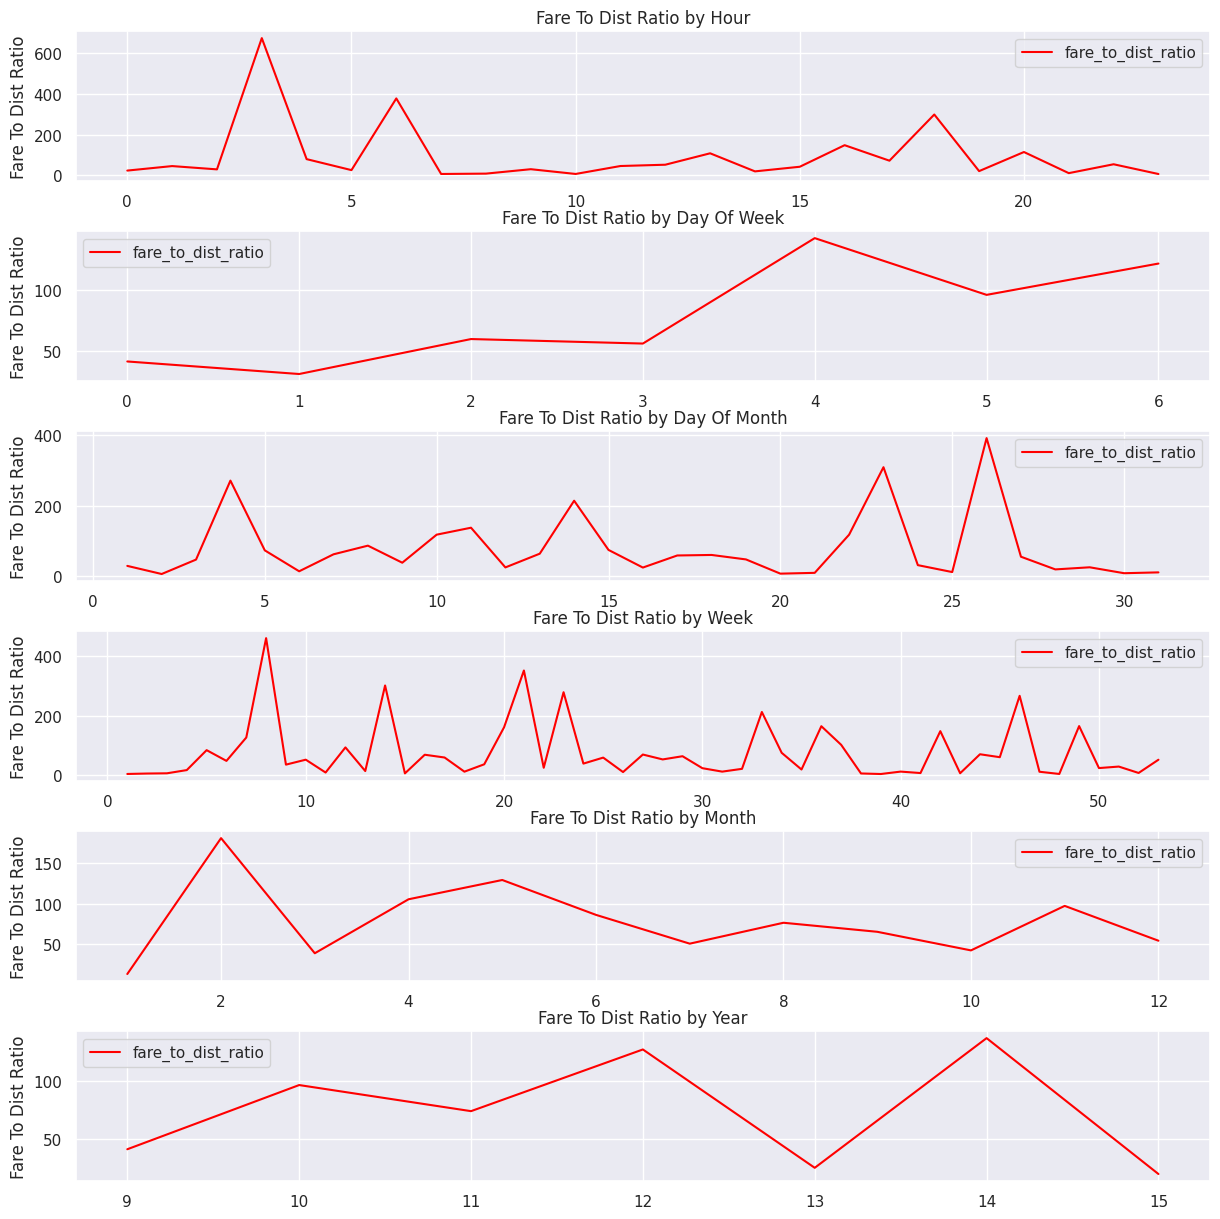

In [51]:
time_slicer(df=train, timeframes=['hour', 'day_of_week','day_of_month', 'week', 'month', 'year',], value = "fare_to_dist_ratio", color="red")

* #### The price of 1 km is high at the beginning of the day and decreases during the day
* #### The price of 1 km increases during the week
* #### The price of 1 km decreases during the months

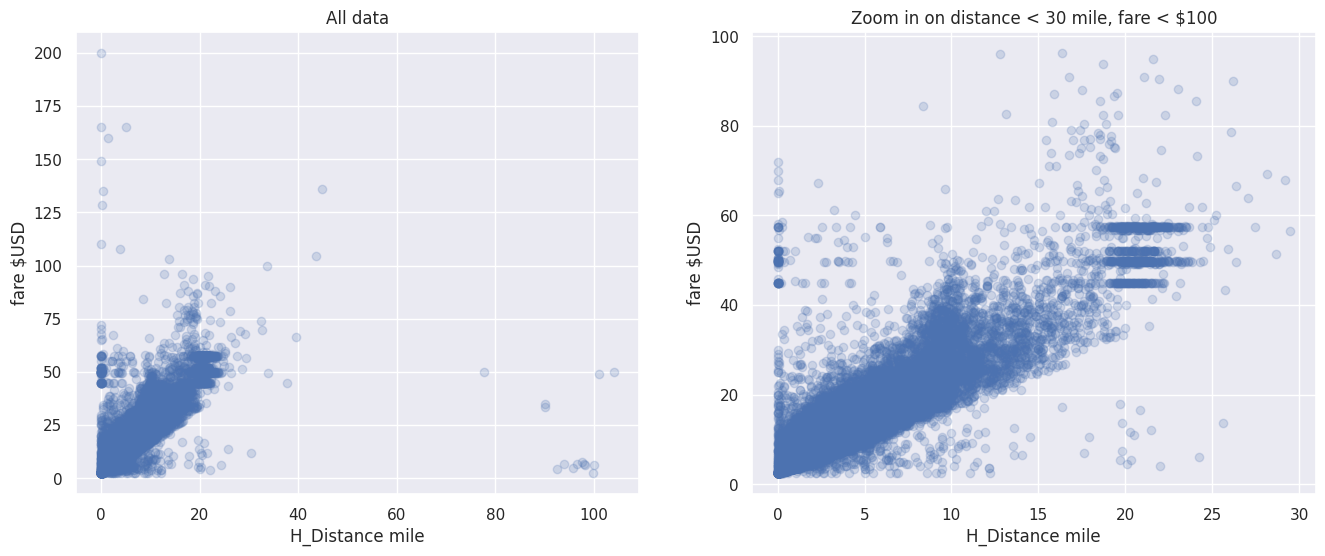

In [52]:
# scatter plot distance - fare
fig, axs = plt.subplots(1, 2, figsize=(16,6))
axs[0].scatter(train.H_Distance, train.amount, alpha=0.2)
axs[0].set_xlabel('H_Distance mile')
axs[0].set_ylabel('fare $USD')
axs[0].set_title('All data')

# zoom in on part of data
idx = (train.H_Distance < 30) & (train.amount < 100)
axs[1].scatter(train[idx].H_Distance, train[idx].amount, alpha=0.2)
axs[1].set_xlabel('H_Distance mile')
axs[1].set_ylabel('fare $USD')
axs[1].set_title('Zoom in on distance < 30 mile, fare < $100');

In [53]:
print("Average $USD/Km : {:0.2f}".format(train.amount.sum()/train.H_Distance.sum()))

Average $USD/Km : 3.35


* #### The horizontal lines on the graph to the right may indicate fixed fares from the airport
* #### Overall, a linear relationship is observed

In [54]:
train.reset_index(drop=True, inplace=True)

train[train["fare_to_dist_ratio"]>500]

,unique_id,amount,date_time_of_pickup,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger,loc1,loc2,...,minute,second,dayofyear,fare_to_dist_ratio,pickup_jfk_distance,dropof_jfk_distance,pickup_ewr_distance,dropof_ewr_distance,pickup_lga_distance,dropof_lga_distance
179,52:00.0,4.50,2013-02-06 14:52:00+00:00,-73.972069,40.755692,-73.972084,40.755726,2,"(40.755692, -73.972072)","(40.755727, -73.972082)",...,52,0,37,1102.418640,20.773142,20.776215,17.991293,17.992033,8.712531,8.712268
492,39:00.0,49.57,2010-10-23 18:39:00+00:00,-73.782211,40.644272,-73.782219,40.644272,2,"(40.644272, -73.782215)","(40.64427, -73.782217)",...,39,0,296,130735.660336,0.578554,0.578442,33.027206,33.027077,16.634094,16.634214
595,24:51.0,16.00,2013-10-05 20:24:51+00:00,-73.794113,40.657059,-73.794128,40.657040,1,"(40.657058, -73.794116)","(40.657039, -73.794132)",...,24,51,278,6137.265279,2.316516,2.315508,31.827093,31.826021,14.912458,14.913754
1111,45:59.0,9.50,2015-01-11 22:45:59+00:00,-73.907997,40.857380,-73.908073,40.857361,1,"(40.85737991, -73.90799713)","(40.85736084, -73.90807343)",...,45,59,11,1385.199783,26.533884,26.534586,28.595821,28.589533,9.394489,9.394516
1435,49:13.0,165.00,2009-08-07 21:49:13+00:00,-73.633362,41.032490,-73.633675,41.032597,1,"(41.03249, -73.633363)","(41.032598, -73.633671)",...,49,13,219,5771.377175,45.357388,45.361961,58.781387,58.769257,34.781895,34.776733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47651,43:00.0,45.00,2011-08-08 17:43:00+00:00,-73.781898,40.644814,-73.781555,40.644798,5,"(40.644813, -73.781895)","(40.644798, -73.781553)",...,43,0,220,1551.567994,0.620314,0.607535,33.044003,33.072742,16.593039,16.607821
47897,41:46.0,11.30,2010-08-11 13:41:46+00:00,-73.981277,40.759007,-73.981255,40.759026,1,"(40.759007, -73.981277)","(40.759025, -73.981253)",...,41,46,223,3837.427441,21.610880,21.610508,17.432636,17.435316,9.373388,9.370981
47942,40:00.0,2.50,2009-02-21 15:40:00+00:00,-73.981850,40.774242,-73.981827,40.774231,2,"(40.774242, -73.981853)","(40.77423, -73.981827)",...,40,0,52,938.456346,22.725136,22.722609,18.172390,18.173620,9.204787,9.202649
48033,59:00.0,26.90,2009-10-13 13:59:00+00:00,-74.222153,40.653385,-74.222618,40.653194,2,"(40.653385, -74.222153)","(40.653193, -74.22262)",...,59,0,286,598.988595,37.428288,37.466846,6.269504,6.312696,32.520512,32.565247


<ipython-input-55-22bdfc25189c>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  passenger_fare = train.groupby(['no_of_passenger']).mean()


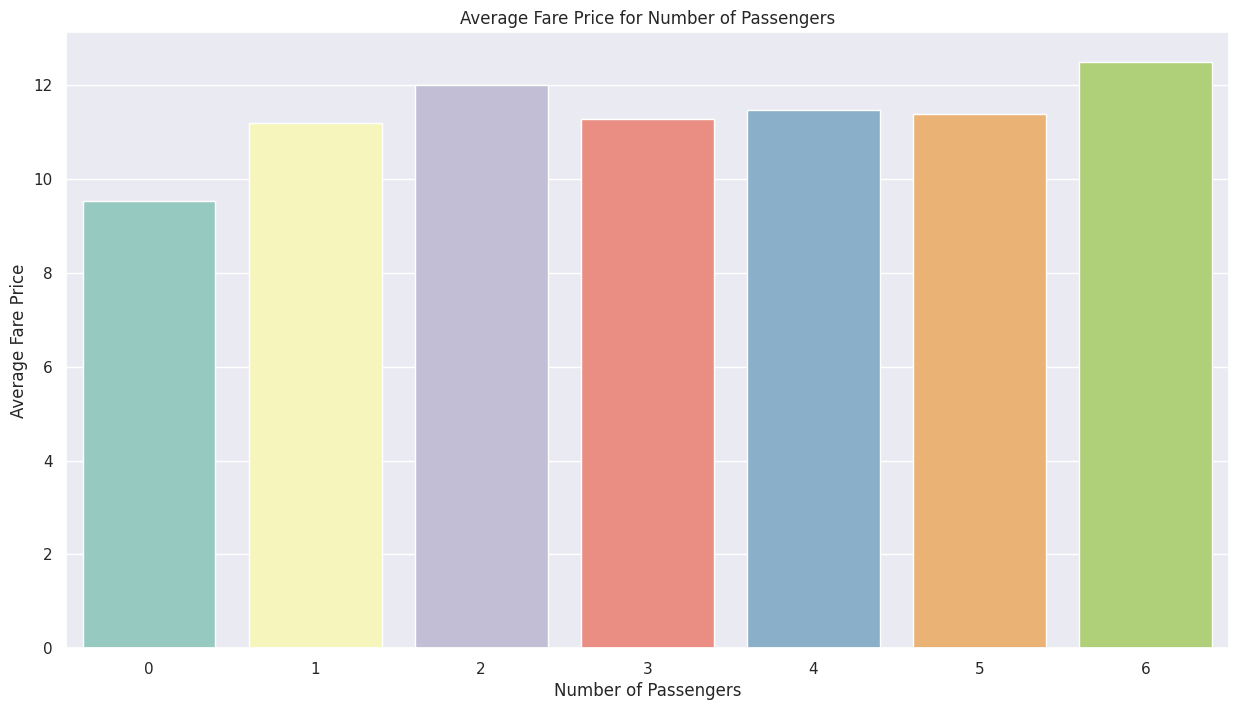

In [55]:
passenger_fare = train.groupby(['no_of_passenger']).mean()
sns.barplot(x=passenger_fare.index, y=passenger_fare['amount'], palette = "Set3")
plt.xlabel('Number of Passengers')
plt.ylabel('Average Fare Price')
plt.title('Average Fare Price for Number of Passengers')
plt.show()

# Data Preprocess

In [56]:
train.drop(['unique_id', 'date_time_of_pickup',"fare_to_dist_ratio",'loc1', 'loc2'], axis=1, inplace=True)

# test_unique_id = pd.DataFrame(test['unique_id'])
# test.drop(['unique_id', 'date_time_of_pickup','loc1','loc2',], axis=1, inplace=True)

In [57]:
print(train.columns)
print(train.dtypes)

Index(['amount', 'longitude_of_pickup', 'latitude_of_pickup',
       'longitude_of_dropoff', 'latitude_of_dropoff', 'no_of_passenger',
       'H_Distance', 'Chebyshev', 'hour', 'day_of_week', 'day_of_month',
       'week', 'month', 'year', 'minute', 'second', 'dayofyear',
       'pickup_jfk_distance', 'dropof_jfk_distance', 'pickup_ewr_distance',
       'dropof_ewr_distance', 'pickup_lga_distance', 'dropof_lga_distance'],
      dtype='object')
amount                  float32
longitude_of_pickup     float32
latitude_of_pickup      float32
longitude_of_dropoff    float32
latitude_of_dropoff     float32
no_of_passenger           uint8
H_Distance              float32
Chebyshev               float32
hour                      uint8
day_of_week               uint8
day_of_month              uint8
week                      uint8
month                     uint8
year                      uint8
minute                    uint8
second                    uint8
dayofyear                uint16
pickup_j

In [58]:

print(test.dtypes)

unique_id                object
amount                  float32
date_time_of_pickup      object
longitude_of_pickup     float32
latitude_of_pickup      float32
longitude_of_dropoff    float32
latitude_of_dropoff     float32
no_of_passenger           uint8
dtype: object


#### Split Data

In [59]:
X = train.iloc[:,train.columns != "amount"]
y = train["amount"]
X_test = test
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.75, test_size=0.15, random_state=42, shuffle=True)


# scaler = MinMaxScaler(feature_range=(0, 1))

# X_train_scaled = scaler.fit_transform(X_train)
# X_train = pd.DataFrame(X_train_scaled)

# X_valid_scaled = scaler.fit_transform(X_valid)
# X_valid = pd.DataFrame(X_valid_scaled)

# X_test_scaled = scaler.fit_transform(X_test)
# X_test = pd.DataFrame(X_test_scaled)

## Model 1 : Linear Regression

In [60]:
# def Linear_reg(X_train, X_valid, y_train, y_valid):
#     linear = LinearRegression()
#     linear.fit(X_train, y_train)

#     y_train_predict = linear.predict(X_train)
#     r2_train = r2_score(y_train, y_train_predict)
#     RMSE_train = mean_squared_error(y_train, y_train_predict, squared=False)

#     y_valid_predict = linear.predict(X_valid)
#     r2_valid = r2_score(y_valid, y_valid_predict)
#     RMSE_valid = mean_squared_error(y_valid, y_valid_predict, squared=False)

#     return r2_train, r2_valid, linear,RMSE_train,RMSE_valid

# r2_train, r2_valid, linear,RMSE_train,RMSE_valid = Linear_reg(X_train, X_valid, y_train, y_valid)

# #print("R^2 (train) : ", r2_train)
# print("RMSE (train): ", RMSE_train)
# #print("R^2 (valid) : ", r2_valid)
# print("RMSE (valid): ", RMSE_valid)


* RMSE (train):  1.3202917e-05
* RMSE (valid):  1.4740558

## Model 2 : Polynomial Regression


In [61]:
# def Poly_reg(X_train, X_valid, y_train, y_valid, degree={'degree' : 2}):
#     poly = PolynomialFeatures(degree=degree['degree'])
#     X_train_ = poly.fit_transform(X_train)
#     est_poly = LinearRegression()
#     est_poly.fit(X_train_,y_train)

#     y_train_predict = est_poly.predict(X_train_)
#     r2_train = r2_score(y_train, y_train_predict)
#     RMSE_train = mean_squared_error(y_train, y_train_predict, squared=False)


#     X_valid_ = poly.fit_transform(X_valid)

#     y_valid_predict = est_poly.predict(X_valid_)
#     r2_valid = r2_score(y_valid, y_valid_predict)
#     RMSE_valid = mean_squared_error(y_valid, y_valid_predict, squared=False)

#     return r2_train, r2_valid, RMSE_train, RMSE_valid

# for deg in range(1,5):
#     degree={'degree' : deg}
#     r2_train, r2_valid,RMSE_train, RMSE_valid = Poly_reg(X_train, X_valid, y_train, y_valid, degree)
#     print("Polynomial degree", deg)
#     print("R^2 (train) : ", r2_train)
#     print("RMSE (train): ", RMSE_train)
#     print("R^2 (valid) : ", r2_valid)
#     print("RMSE (valid): ", RMSE_valid)

* Polynomial degree 1
* R^2 (train) :  0.9999999999953564
* RMSE (train):  2.0643134e-05
* R^2 (valid) :  0.3986446655631378
* RMSE (valid):  7.342692
* Polynomial degree 2
* R^2 (train) :  0.9999999998963758
* RMSE (train):  9.751603e-05
* R^2 (valid) :  0.40283202490610714
* RMSE (valid):  7.317083
* Polynomial degree 3
* R^2 (train) :  0.999999991415696
* RMSE (train):  0.00088756054
* R^2 (valid) :  0.39955006653268765
* RMSE (valid):  7.3371625

## Model 2 : Ridge Regression

In [62]:

# model = Ridge(alpha=1.0)
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# scores = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# scores = absolute(scores)
# print('rmse: %.3f (%.3f)' % (mean(scores), std(scores)))

rmse: 0.041 (0.003)

## Model 3: DECISION TREE REGRESSOR MODEL

In [63]:
# dtr = DecisionTreeRegressor().fit(X_train, y_train)
# y_valid_pred = dtr.predict(X_valid)



# # Root Mean Square Error
# rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
# print("RMSE: %f" % (rmse))

# # Mean Squared Error
# print("Mean squared error: %.2f"
#       % mean_squared_error(y_valid, y_valid_pred))

# # R2 Score
# print('Variance score: %.2f' % r2_score(y_valid, y_valid_pred))

* RMSE: 1.474739
* Mean squared error: 2.17
* Variance score: 0.98
* when size = 1000000

## Model 4: KNR

In [64]:
# rmse_val = []
# for K in range(20):
#     K = K+1
#     model = neighbors.KNeighborsRegressor(n_neighbors = K)

#     model.fit(X_train, y_train)
#     pred=model.predict(X_valid)
#     error = sqrt(mean_squared_error(y_valid,pred))
#     rmse_val.append(error)
#     print('RMSE value for k= ' , K , 'is:', error)

In [65]:
# curve = pd.DataFrame(rmse_val)
# curve.plot()

## Model 5: Support Vector Machines

In [66]:
# svr = svm.LinearSVR()
# svr.fit(X_train,y_train)
# test_val_pred_svr = svr.predict(X_test_val)
# np.sqrt(metrics.mean_squared_error(y_test_val,test_val_pred_svr))

## Model 6: Neural Network

In [67]:
# early_stop = EarlyStopping(monitor='val_loss', mode='min', min_delta=1e-3, patience=3)
# callback=[early_stop]
# adam = Adam(lr=0.0001)

# model = Sequential()
# model.add(Dense(100, activation='relu', input_shape=(train.shape[1],)))
# model.add(Dropout(0.6))
# model.add(Dense(80, activation='relu'))
# model.add(Dropout(0.6))
# model.add(Dense(40, activation='relu'))
# model.add(Dropout(0.6))
# model.add(Dense(1, activation='linear'))
# model.compile(loss='mse', optimizer=adam, metrics=['mae'])
# history = model.fit(X_train,y_train,batch_size=256, epochs=50, verbose=1, callbacks=callback,
#          validation_data=(X_valid, y_valid), shuffle=True)

In [68]:
# # summarize history for loss using learning curve
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [69]:
# y_pred = np.array(model.predict(X_valid))
# print(sqrt(mean_squared_error(y_valid, y_pred)))

## Model 7: XGBoost

In [70]:
params = {

    'max_depth': 7,
    'gamma' :0,
    'eta':.03,
    'subsample': 1,
    'colsample_bytree': 0.9,
    'objective':'reg:linear',
    'eval_metric':'rmse',
    'silent': 0,
    'verbosity' : 0,
    'random_state' : 42
}

In [71]:
def XGBmodel(X_train,X_valid,y_train,y_valid,params):
    matrix_train = xgb.DMatrix(X_train,label=y_train)
    matrix_valid = xgb.DMatrix(X_valid,label=y_valid)
    model=xgb.train(params=params,
                    dtrain=matrix_train,num_boost_round=5000,
                    early_stopping_rounds=10,evals=[(matrix_valid,'valid')])
    return model

model = XGBmodel(X_train,X_valid,y_train,y_valid,params)

[0]	valid-rmse:13.97646
[1]	valid-rmse:13.59033
[2]	valid-rmse:13.21584
[3]	valid-rmse:12.85374
[4]	valid-rmse:12.50287
[5]	valid-rmse:12.16312
[6]	valid-rmse:11.83660
[7]	valid-rmse:11.52074
[8]	valid-rmse:11.21632
[9]	valid-rmse:10.92190
[10]	valid-rmse:10.63856
[11]	valid-rmse:10.36388
[12]	valid-rmse:10.09969
[13]	valid-rmse:9.84374
[14]	valid-rmse:9.59497
[15]	valid-rmse:9.35407
[16]	valid-rmse:9.12377
[17]	valid-rmse:8.90012
[18]	valid-rmse:8.68573
[19]	valid-rmse:8.47713
[20]	valid-rmse:8.27729
[21]	valid-rmse:8.08545
[22]	valid-rmse:7.89792
[23]	valid-rmse:7.72102
[24]	valid-rmse:7.54786
[25]	valid-rmse:7.38042
[26]	valid-rmse:7.22240
[27]	valid-rmse:7.06830
[28]	valid-rmse:6.92004
[29]	valid-rmse:6.77747
[30]	valid-rmse:6.63892
[31]	valid-rmse:6.50747
[32]	valid-rmse:6.38173
[33]	valid-rmse:6.25933
[34]	valid-rmse:6.14346
[35]	valid-rmse:6.03360
[36]	valid-rmse:5.92596
[37]	valid-rmse:5.82306
[38]	valid-rmse:5.72541
[39]	valid-rmse:5.63353
[40]	valid-rmse:5.54356
[41]	valid-rm

In [72]:
y = model.predict(xgb.DMatrix(X_valid), ntree_limit = model.best_ntree_limit).tolist()

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


<Axes: xlabel='X'>

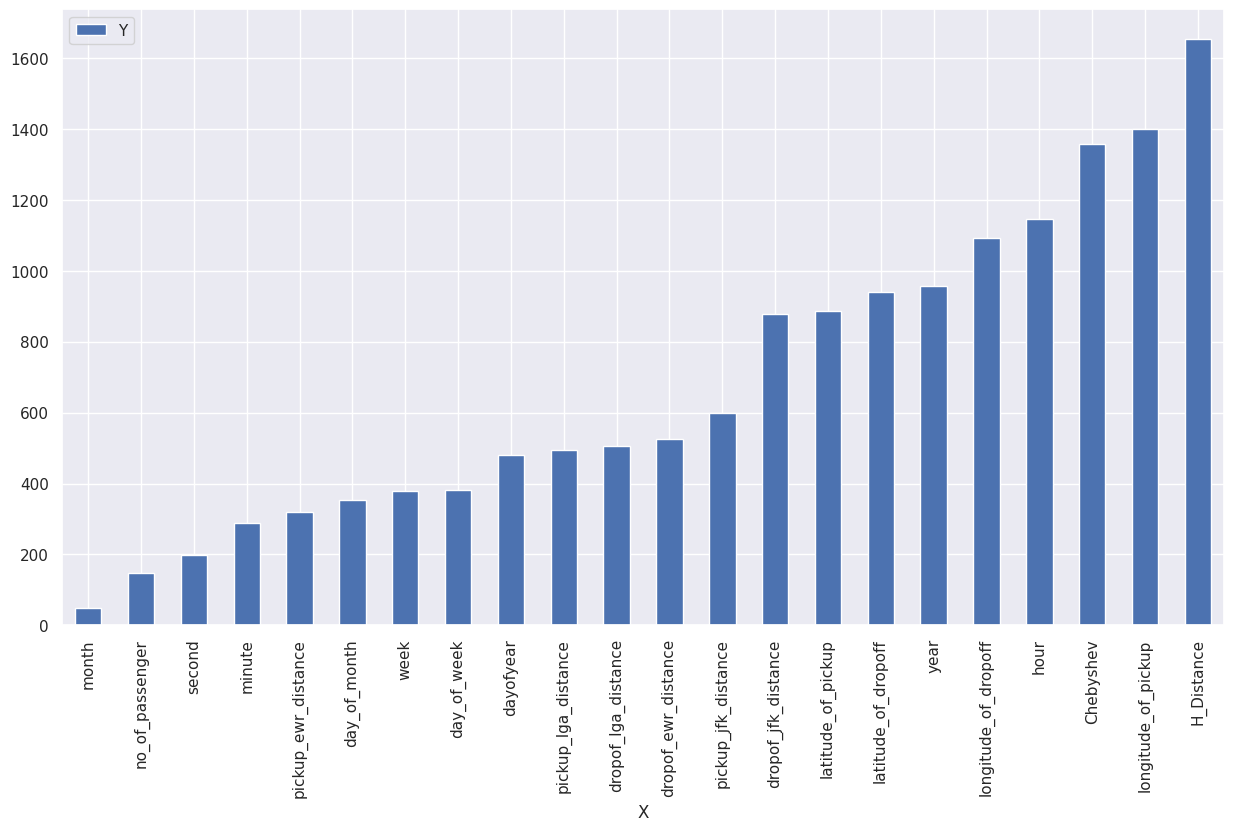

In [73]:
fscores = pd.DataFrame({'X': list(model.get_fscore().keys()), 'Y': list(model.get_fscore().values())})
fscores.sort_values(by='Y').plot.bar(x='X')

## Submition

### Model 6: Neural Network

In [74]:
# subm =  pd.read_csv('......')
# subm.amount = y
# subm.to_csv('submission.csv',index=False)
# print("Submitted")